# Facebook Data Miner

This notebook is about showcasing the features of this python application through it's API. 

## Introduction (skip, if you came for the code)

One day I downloaded my facebook data, and it turned out it's 8.2GBs. That's a lot. I started looking into directories, and found same interesting media files, chat messages and posts. I wanted to dive deeper, but I knew I can't scale it after some point.

Then I googled `facebook data analyzer github`, so that I can just download a package that does the analysis. As you can see in this [list](https://github.com/topics/facebook-data-analyzer) it - as of September 2020 - is not a whole lot. 

There is a nice library written in Ruby with more than 100 commits and 505 stars, but it's more than 2 years old now. The other thing is that I was looking for a solution with which I can mess around (e.g. maybe use the data getters to do some basic machine learning on my message history) and I didn't really want to get into Ruby.

There are also some Python packages, but they offer little-to-no data interfaces. Most of them focus on visualizing the results with plots, and the data getters were desgined around the plotter functions. Although you may want to check out [fviz](https://github.com/itzmeanjan/fviz) which offers really nice plots. Probably nicer then this library would ever have. 

## Purpose

Then I decided that I would write my own library for this, amongst others for two main reasons:

1. I want to have really specific insights from my facebook data.
2. I want to improve my Python and get expertise in Python's data science libraries, build and packaging tools. Gaining some more git, GitHub, software design and project planning skills would be a plus.

## Requirements
### Setup env
#### Packages

Set up the pipenv environment.
```
pipenv install
```

In order to run this notebook, you may want a `jupyter lab` or `jupyter notebook` (this is installed with pipenv already).


#### Changing shebang in ./miner/cli.py
In order to run the notebook cells without explicitly typing python, you need to change this line in the `./miner/cli.py` file's first row:
```python
#!/home/user/.local/share/virtualenvs/facebook-data-miner--PToUZxx/bin/python
```
to the path where your virtual environment's python is.


#### Env vars

Before starting jupyter notebook you will have to export two enviroenment variables. Run these comamnds from the root of the project.

For having the project path added to pythhon search $PATH:
```bash
export PYTHONPATH="$PWD"
```
Also make sure to set pipenv verbosity, otherwise you will get unncessary info messages from pipenv:
```bash
export PIPENV_VERBOSITY=-1
```

### Setting data path

In order to run this notebook, you need to specify the data path where your Facebook data is. Search for the file `configuration.yml` in the root of this project, and set the `DATA_PATH` variable either to the zip file's absolute path, or if you have already extracted it, the absolute path of the data directory.

## Analyzing your Facebook data
For getting your Facebook data refer to the [README.md](README.md) file. 

First we import all the dependencies we will need for running the notebook.

In [1]:
import os
from datetime import datetime
from IPython.display import Image
from inspect import signature


from miner.app import App
from miner.utils import utils

In [2]:
tmp = !git rev-parse --show-toplevel
BASE_PATH = tmp[0]
BASE_PATH

'/home/levente/projects/facebook-data-miner'

In [3]:
try:
    if not os.getcwd() == BASE_PATH:
        os.chdir(BASE_PATH)
        print(f"OK! Changed to: {os.getcwd()} directory.")
except:
	print(f"WARNING! Couldn't change directory. Current is: {os.getcwd()}")

OK! Changed to: /home/levente/projects/facebook-data-miner directory.


## Application

This notebook will give you a good grasp on how this application works, and how can you use it.

Let's dive right into it. The execution of this cell might take a while depending on how much data you have and how fast is your CPU. Right now the constructor of this class unzips the zipfile if not unzipped yet, reads in the json files we are analyzing, and creates some basic data structures from them.

In [4]:
app = App() 

Let's see what's in the box.

In [5]:
!ls data

about_you			      marketplace
ads_and_businesses		      messages
apps_and_websites		      other_activity
comments			      pages
events				      payment_history
facebook_gaming			      photos_and_videos
files				      posts
following_and_followers		      profile_information
friends				      saved_items_and_collections
groups				      search_history
information_used_for_recommendations  security_and_login_information
interactions			      stories
lasso				      voice_recording_and_transcription
likes_and_reactions		      wordlist-hu-0.3.tar.bz2
location			      your_places


These are the categories in which Facebook ordered the data they have on you. 

In this notebook we will focus on `friends` and `messages`.

### Friends
The first feature we have is a straightforward one. We get our friends from Facebook, and the date the connection was made.

For this Facebook provides us with the `friends` directory/category. Here is what is inside.

In [6]:
!ls data/friends

friends.json		       removed_friends.json
received_friend_requests.json  sent_friend_requests.json
rejected_friend_requests.json


In [7]:
friends = app.friends
friends

<Storing 9 friends>

We can have a look what kind of methods and properties does this object expose. We use a wrapper around the `dir` built-in, thus we only see methods and properties which does not start with an underscore.

In [8]:
def dir_stripped(obj):
    return [prop for prop in dir(obj) if not prop.startswith('_')]

In [9]:
print(dir_stripped(friends))

['data', 'get', 'metadata', 'path', 'preprocessor', 'reader']


The `data` property of the `friends` object is a pandas DataFrame that contains all of your Facebook friends. Timestamps refer to the datetime of making the Facebook freinds. 

Here are 5 samples from the friends DataFrame.

In [10]:
friends.data.sample(5)

,name
timestamp,
2020-05-28 13:41:59+00:00,John Doe
2020-02-21 13:07:59+00:00,Tőke Hal
2020-02-06 14:26:40+00:00,Daisy Duck
2020-03-15 19:18:28+00:00,Szett Droxler
2020-02-06 14:29:01+00:00,Bugs Bunny


Let's see what pandas can tell us about the DataFrame.

In [11]:
friends.data.describe()

,name
count,9
unique,9
top,Donald Duck
freq,1


You can also get a string version of this, with the get command. I won't go too much into the details, check out its docstring or check out the CLI notebook.
You can also write to file with this, but I will cover this in the next section.

In [12]:
print(friends.get())

timestamp,name
2020-02-06 14:25:00+00:00,Guy Fawkes
2020-02-06 14:26:40+00:00,Daisy Duck
2020-02-06 14:29:01+00:00,Bugs Bunny
2020-02-12 16:01:52+00:00,Dér Dénes
2020-02-21 13:07:59+00:00,Tőke Hal
2020-03-14 20:54:52+00:00,Foo Bar
2020-03-15 19:18:28+00:00,Szett Droxler
2020-04-09 19:42:05+00:00,Donald Duck
2020-05-28 13:41:59+00:00,John Doe



### Conversations

`Conversations` is a class that reads and stores conversation data, that is both `private` and `group` messages.

Both `private` and `group` properties of the Conversations class has the type of `Dict[str, Conversation]`, where:
* a `key` is either private conversation partners or group conversation names (basically the name of the channel),
* a `value` is a type of `Conversation`, which is a container class that contains a channel's data and metadata.

The difference between `private` and `group` is not at all that big. The reason behind the design decision to deal with them separately comes down to the fact that the relation between participants and channels is different (in private one participant can relate to only one channel, while in group messages one participant can realte to a number of channels). Although symmetry is still kept by using the same classes for both of them (no subclasses).

In [13]:
conversations = app.conversations
conversations

<Conversations for private4, group: 3>

In [14]:
print(dir_stripped(conversations))

['get', 'group', 'path', 'private']


We have these two properties to use. We can check how many private and how many group conversations do we have.

In [15]:
len(conversations.private), len(conversations.group)

(4, 3)

With conversations.get function you can get the data in a text format You can filter it and write it in a file.

In [16]:
print(conversations.get(kind='group', cols=['content', 'partner']))

timestamp_ms,content,partner
2011-07-17 13:00:06.580000+00:00,test,"Tőke Hal, Foo Bar, Donald Duck and 2 others"
2011-07-17 13:00:08.580000+00:00,test,"Foo Bar, John Doe and Bugs Bunny"
2011-07-17 13:00:13.721000+00:00,what do you test,"Tőke Hal, Foo Bar, Donald Duck and 2 others"
2011-07-17 13:00:13.721000+00:00,what do you test,"Foo Bar, John Doe and Bugs Bunny"
2011-07-17 13:00:32.011000+00:00,basic group messages,"Tőke Hal, Foo Bar, Donald Duck and 2 others"
2011-07-17 13:00:32.012000+00:00,blabla,"Tőke Hal, Foo Bar, Donald Duck and 2 others"
2011-07-17 13:00:32.012000+00:00,basic group messages,"Foo Bar, John Doe and Bugs Bunny"
2011-07-17 13:02:54.237000+00:00,ok,"Foo Bar, John Doe and Bugs Bunny"
2011-07-17 13:02:54.237000+00:00,ok,"Tőke Hal, Foo Bar, Donald Duck and 2 others"
2018-04-19 10:31:42.152000+00:00,marathon?,marathon
2018-04-19 10:32:21.074000+00:00,yapp yapp :D,marathon
2018-04-19 10:32:35.273000+00:00,You named the group marathon.,marathon
2018-04-19 11:35:37.066000

Notice that this ouput is formatted as a CSV. You can aslo format it as a `json`. Just pass `json` as the value of the `--output` flag.

In [17]:
conversations.get(kind='group', channels='marathon',cols=['content', 'partner', 'sender_name'], output='json')

'{"schema":{"fields":[{"name":"timestamp_ms","type":"datetime","tz":"UTC"},{"name":"content","type":"string"},{"name":"partner","type":"string"},{"name":"sender_name","type":"string"}],"primaryKey":["timestamp_ms"],"pandas_version":"0.20.0"},"data":[{"timestamp_ms":"2018-04-19T10:31:42.152Z","content":"marathon?","partner":"marathon","sender_name":"Jen\\u0151 Rejt\\u0151"},{"timestamp_ms":"2018-04-19T10:32:21.074Z","content":"yapp yapp :D","partner":"marathon","sender_name":"Foo Bar"},{"timestamp_ms":"2018-04-19T10:32:35.273Z","content":"You named the group marathon.","partner":"marathon","sender_name":"Jen\\u0151 Rejt\\u0151"},{"timestamp_ms":"2018-04-19T11:35:37.066Z","content":null,"partner":"marathon","sender_name":"Donald Duck"},{"timestamp_ms":"2018-04-19T11:35:49.717Z","content":"i start today","partner":"marathon","sender_name":"Donald Duck"},{"timestamp_ms":"2018-04-19T11:37:39.673Z","content":null,"partner":"marathon","sender_name":"Donald Duck"},{"timestamp_ms":"2018-04-19T1

We can also write this to an output file instead of stdout.

In [18]:
conversations.get(kind='group', channels='marathon',cols=['content', 'partner', 'sender_name'], output=f'{BASE_PATH}/convos.csv')

'Data was written to /home/levente/projects/facebook-data-miner/convos.csv'

In [19]:
!cat $BASE_PATH/convos.csv

timestamp_ms,content,partner,sender_name
2018-04-19 10:31:42.152000+00:00,marathon?,marathon,Jenő Rejtő
2018-04-19 10:32:21.074000+00:00,yapp yapp :D,marathon,Foo Bar
2018-04-19 10:32:35.273000+00:00,You named the group marathon.,marathon,Jenő Rejtő
2018-04-19 11:35:37.066000+00:00,,marathon,Donald Duck
2018-04-19 11:35:49.717000+00:00,i start today,marathon,Donald Duck
2018-04-19 11:37:39.673000+00:00,,marathon,Donald Duck
2018-04-19 11:38:02.444000+00:00,we could go but running is free,marathon,Donald Duck
2018-04-19 11:38:32.776000+00:00,hmmm,marathon,Jenő Rejtő
2018-04-19 12:52:39.709000+00:00,:D,marathon,Donald Duck


In [20]:
!rm $BASE_PATH/convos.csv

### Messaging Analyzer
Now we got to a point where we can actually *analyze* our data. 

`app.analyzer` returns an instance of `MessagingAnalyzerManager` which manages the analysis of both `private` and `group` messages, and also the interaction between the two e.g. get all messages for one person (both private and all the group channels).

**IMPORTANT NOTE**: For discover the features of this class and its composite classes, we want to be able to refer to at least one private conversation partner and at least one group conversation. 
In the next cell you should set this variables to a private conversation partner's name and the name of a group conversation of yours.

In [21]:
PARTNER_NAME = "Foo Bar"

GROUP_NAME = 'marathon' 

Now we can go ahead and start our discoveries. 

In [22]:
analyzer = app.analyzer

If we run the next cell, we will see that this object has a lot of methods and properties.

In [23]:
print(dir_stripped(analyzer))

['all_interactions', 'config', 'conversations', 'get_stats_together', 'get_who_i_have_private_convo_with_from_a_group', 'group', 'group_messaging_analyzer', 'how_much_i_speak_in_private_with_group_members', 'is_private_convo_first_then_group', 'people_i_have_group_convo_with', 'people_i_have_private_convo_with', 'private', 'private_messaging_analyzer']


Let's now take the above group and see amongst its participants who we have private conversation with.

In [24]:
analyzer.get_who_i_have_private_convo_with_from_a_group(GROUP_NAME)

['Bugs Bunny', 'Foo Bar']

Now we can also check how much I speak with these participants.

In [25]:
analyzer.how_much_i_speak_in_private_with_group_members(GROUP_NAME)

{'Bugs Bunny': 6, 'Foo Bar': 15}

Let's see if I had first private or group messages first with the above partner.

In [26]:
analyzer.is_private_convo_first_then_group(PARTNER_NAME)

True

Now let's get all the stats for one person. The return value of `get_stats_together` is only the `ConversationStats` calulated on messages sent by the partner in either of the channels. 

Note: we will cover `ConversationStats` soon.

In [27]:
stats = analyzer.get_stats_together(PARTNER_NAME)

Now we can print some statistics from this object, just so we see how it is working. But let's not spoil too much from this object.

In [28]:
stats.number_of_channels

4

In [29]:
count = 5 if stats.number_of_channels > 5 else stats.number_of_channels
stats.channels[:count]

['Tőke Hal, Foo Bar, Donald Duck and 2 others',
 'Foo Bar, John Doe and Bugs Bunny',
 'marathon',
 'Foo Bar']

In [30]:
stats.df.sample(5)

,sender_name,content,type,audio_files,gifs,reactions,files,partner
timestamp_ms,,,,,,,,
2018-04-19 10:32:21.074000+00:00,Foo Bar,yapp yapp :D,Generic,NaN,NaN,NaN,NaN,marathon
2011-07-17 13:00:13.721000+00:00,Foo Bar,what do you test,Generic,NaN,NaN,NaN,NaN,"Foo Bar, John Doe and Bugs Bunny"
2020-02-13 05:15:38.715000+00:00,Foo Bar,Ut akar ... consequat. oO wow :P xd :D,Generic,NaN,NaN,"[{'reaction': '❤', 'actor': 'Jenő Rejtő'}]",NaN,Foo Bar
2020-02-14 03:28:48.047000+00:00,Foo Bar,NaN,Generic,NaN,NaN,NaN,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/fil...,Foo Bar
2020-03-09 10:48:48.047000+00:00,Foo Bar,NaN,Generic,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/aud...,NaN,NaN,NaN,Foo Bar


### Private and Group Messaging Analyzer


So let's finally see the similarities and differences between `private` and `group` analyzers by looking into these objects. 

It might be helpful for us to know, that both of these objects are created by passing their constructor the `Conversations`' private and group properties. That means: `analyzer.private.data = conversations.private` and `analyzer.group.data = conversations.group`.

In [31]:
private = analyzer.private
group = analyzer.group

In [32]:
assert type(private) == type(group)
group

<Group-MessagingAnalyzer for 3 channels>

As you can see both objects are instances of `MesagingAnalyzer` class. Every property and method is available for both types of conversations, although some properties makes more sense for one or the other. 

First we get the number of channels.

In [33]:
len(private), len(group)

(4, 3)

Then let's list all the properties and methods we can use with these objects.

In [34]:
print(dir_stripped(private))

['config', 'data', 'df', 'filter', 'get_all_channels_for_one_person', 'get_ranking_of_people_by_convo_stats', 'get_stat_count', 'is_group', 'max_channel_size', 'mean_channel_size', 'min_channel_size', 'number_of_convos_created_by_me', 'participant_to_channel_map', 'participants', 'stats', 'stats_per_channel', 'stats_per_participant']


We have this `is_group` property, which should be pretty intuitive.

In [35]:
private.is_group, group.is_group

(False, True)

Let's see the number of all the messages ever sent from any party in private and in group messages. We do this by inspecting the shape of the DataFrame bound to these objects. 

Here we should mention, that `private.df` or `group.df` is created by stacking together all the `Conversation` DataFrames these objects contain. 

In [36]:
private.df.shape[0], group.df.shape[0]

(31, 18)

Let's see the number of participants. Note, that e.g. for me this is not the same as `len(private), len(group)` but it is only because some weird unicode (or not) characters.

In [37]:
len(private.participants), len(group.participants)

(5, 8)

Let's see the ranking of my friends by messages sent. It could be very different for private and group messages.

In [38]:
by_count, by_percent = private.get_ranking_of_people_by_convo_stats(statistic='mc', top=10)
by_count

'count'

In [39]:
by_count, by_percent = group.get_ranking_of_people_by_convo_stats(statistic='mc', top=10)
by_percent

'percent'

Chances are your name will appear in the group's ranking and it's because of an important difference in how these values get computed. The `private` object calculates the values by a channel, while `group` object calculates it by senders. It can be a bit confusing, but this seemes the most intuitive solution.

Note that you can also change the metric by which we calculate the portion of contribution. Let's do a calculation based on `character count`.

In [40]:
group.get_ranking_of_people_by_convo_stats(statistic='cc', top=10)

{'count': {'Donald Duck': 42,
  'Jenő Rejtő': 42,
  'Foo Bar': 36,
  'Bugs Bunny': 18,
  'Tőke Hal': 18,
  'Dér Dénes': 6,
  'Facebook User': 2,
  'John Doe': 2},
 'percent': {'Donald Duck': 25.301204819277107,
  'Jenő Rejtő': 25.301204819277107,
  'Foo Bar': 21.686746987951807,
  'Bugs Bunny': 10.843373493975903,
  'Tőke Hal': 10.843373493975903,
  'Dér Dénes': 3.6144578313253013,
  'Facebook User': 1.2048192771084338,
  'John Doe': 1.2048192771084338}}

`get_stat_count` is a function with which you can get specific countable statistics for all of your private or group conversations. This function uses the `ConversationStats` class to get statitics from. The nice thing about this function is that you can filter the undelying `ConversationStats` by channel, sender, date range, type of message. 

Let's now get word count aliased by `wc` of all the messages someone else sent me aliased by `partner`.

In [41]:
private.get_stat_count(attr='wc', senders='partner')

20

In [42]:
group.get_stat_count(attr='wc', senders='partner')
# partner here means: not me

32

We can also count how many conversations was started by me.

In [43]:
private.number_of_convos_created_by_me

4

In [44]:
group.number_of_convos_created_by_me

2

We also have a `{min|mean|max}_channels_size` property, which measures the corresponding statistics for the channels registered in the current analyzer. For private messages it makes less sense, then in group, but for the sake of symmetry, we have these properties for both.

In [45]:
private.min_channel_size, private.max_channel_size


(2, 2)

In [46]:
group.min_channel_size, group.mean_channel_size, group.max_channel_size

(4, 4.666666666666667, 6)

#### Filtering
You can filter the analyzers. Both `private` and `group` conversation analyzers can be filtered along two dimensions. First is `channels`, which is quite straightforward. The other is `senders`. 

In case of `private` messages, `channels` and `senders` are exactly the same, altough calculated a bit differently (I suggest using `channels`, which is faster). 

In case of `group`, `channels` filters by group conversation names, `senders` filters by people who are part of a group message.

Both parameters can be passed as string or list of strings.

The `filter` method will create a new `Analyzer` instance.

Let's first filter private messages.

In [47]:
private_filtered_by_channels = private.filter(channels=PARTNER_NAME)
private_filtered_by_channels

<Private-MessagingAnalyzer for 1 channels>

In [48]:
private_filtered_by_participants = private.filter(participants=PARTNER_NAME)
private_filtered_by_participants

<Private-MessagingAnalyzer for 1 channels>

Let's see the number of meesages in both.

In [49]:
private_filtered_by_channels.df.shape, private_filtered_by_participants.df.shape

((15, 10), (15, 10))

To make sure they yield the same result, we will assert some more properies of the two objects.

In [50]:
private_filtered_by_channels.participants, private_filtered_by_participants.participants

(['Foo Bar', 'Jenő Rejtő'], ['Foo Bar', 'Jenő Rejtő'])

In [51]:
private_filtered_by_channels.number_of_convos_created_by_me, \
private_filtered_by_participants.number_of_convos_created_by_me

(1, 1)

Here the `get_all_groups_for_one_person` method makes little sense. It is the same as the `channels` property of the `stats` object.

In [53]:
private_filtered_by_channels.get_all_channels_for_one_person(PARTNER_NAME) == private_filtered_by_participants.stats.channels

True

Now we can filter the group object as well. Here the two possible filtering parameters actually make sense. 

First we filter by `channels`.

In [54]:
group_filtered_by_channels = group.filter(channels=GROUP_NAME)
group_filtered_by_channels

<Group-MessagingAnalyzer for 1 channels>

The data property should only contian one entry now.

In [55]:
len(group_filtered_by_channels.data.items())

1

In [56]:
group_filtered_by_channels.data.items()

dict_items([('marathon', <miner.message.conversation.Conversation object at 0x7f3009637760>)])

On the other hand if we filter by our chosen partner (defined in `PARTNER_NAME` variable) we may get several groups. In fact all the groups in which our partner has *particiapted* (not neccesserarily contributed).

In [57]:
group_filtered_by_participants = group.filter(participants=PARTNER_NAME)
group_filtered_by_participants

<Group-MessagingAnalyzer for 3 channels>

In [58]:
len(group_filtered_by_participants.data.items())

3

This should be the same number as the return value of the following property of the Analyzer class.

In [59]:
len(group.get_all_channels_for_one_person(PARTNER_NAME))

3

### ConversationStats
As the name suggests this class is a container for holding statsictical data/information about converations. The basic concept is that it does not know general conversation metadata, since it is only constructed by the messages and the metadata of unique messages (who sent it, what kind of messages is it, when was it sent). This object is created by `MessagingAnalyzer` class by passing in the DataFrame as input. The DataFrame is created from all the conversations that the analyzer holds (remember you can filter them, down to a single conversation). 

So to sum it up, `MessagingAnalyzer` knows about the channels and all the metadata of the conversations, while `ConversationStats` only knows about the messages themselves.

`ConversationStats` has a lot of interesting properties and methods, and also a pretty versatile filtering function, so let's discover them.

#### Private and Group Conversation Stats
Note: we follow the strategy of showing private and group conversation stats side-by-side as we did it with the analyzer.

In [60]:
private_stats = private.stats
group_stats = group.stats

Do both of them have the same properties?

In [61]:
assert dir(private_stats) == dir(group_stats)

Seems so... Let's print out the useful ones.

In [62]:
print(dir_stripped(private_stats))

['audios', 'average_word_length', 'cc', 'cc_in_messages', 'channels', 'config', 'contributors', 'created_by_me', 'creator', 'df', 'end', 'files', 'filter', 'get_grouped_time_series_data', 'gifs', 'mc', 'media', 'media_mc', 'message_language_map', 'message_language_ratio', 'messages', 'most_used_msgs', 'most_used_words', 'number_of_channels', 'number_of_contributors', 'percentage_of_media_messages', 'percentage_of_reacted_messages', 'percentage_of_text_messages', 'photos', 'reacted_messages', 'start', 'stats_per_timeframe', 'text', 'text_mc', 'unique_mc', 'unique_wc', 'videos', 'wc', 'wc_in_messages', 'words']


Lets print out one channel from both.

In [63]:
private_stats.channels[0], group_stats.channels[0]

('Bugs Bunny', 'Tőke Hal, Foo Bar, Donald Duck and 2 others')

Let's see the number of channels for both of them. Note that the numbers can be quite familiar. It's because they should be the same as what we saw in case of the Analyzer class.

In [64]:
private_stats.number_of_channels, group_stats.number_of_channels

(4, 3)

Contributors are all the people who ever sent a message. Apparently (at least for me) some of them never did. This is because nowadays, when you make a new friend on Facebook you get connected on Messenger automatically, regardless if you have messages or not.

In [65]:
private_stats.number_of_contributors, group_stats.number_of_contributors

(5, 8)

Your first messages ever (either sent or got).

In [66]:
private_stats.start, group_stats.start

(Timestamp('2014-09-24 15:02:08.715000+0000', tz='UTC'),
 Timestamp('2011-07-17 13:00:06.580000+0000', tz='UTC'))

Last messages before download.

In [67]:
private_stats.end,group_stats.end

(Timestamp('2020-08-08 18:22:08.321000+0000', tz='UTC'),
 Timestamp('2018-04-19 12:52:39.709000+0000', tz='UTC'))

Let's show some samples of our data.

In [68]:
len(private_stats.messages), len(private_stats.df)

(31, 31)

In [69]:
private_stats.messages.sample(5)

,sender_name,content,type,partner,videos,audio_files,photos,gifs,reactions,files
timestamp_ms,,,,,,,,,,
2014-11-10 11:21:46.047000+00:00,Tőke Hal,zup,Generic,Tőke Hal,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-09 22:13:48.715000+00:00,Jenő Rejtő,yo,Generic,Tőke Hal,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-09 22:13:48.715000+00:00,Jenő Rejtő,are you the real Bugs Bunny?,Generic,Bugs Bunny,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-26 12:42:08.145000+00:00,Jenő Rejtő,NaN,Generic,Foo Bar,NaN,NaN,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/pho...,NaN,NaN,NaN
2014-11-10 11:21:46.047000+00:00,Bugs Bunny,no,Generic,Bugs Bunny,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
group_stats.messages.sample(5)

,sender_name,content,type,partner,photos,gifs
timestamp_ms,,,,,,
2018-04-19 11:38:32.776000+00:00,Jenő Rejtő,hmmm,Generic,marathon,NaN,NaN
2011-07-17 13:00:13.721000+00:00,Foo Bar,what do you test,Generic,"Foo Bar, John Doe and Bugs Bunny",NaN,NaN
2011-07-17 13:00:32.012000+00:00,Dér Dénes,blabla,Generic,"Tőke Hal, Foo Bar, Donald Duck and 2 others",NaN,NaN
2011-07-17 13:00:32.012000+00:00,Bugs Bunny,basic group messages,Generic,"Foo Bar, John Doe and Bugs Bunny",NaN,NaN
2011-07-17 13:02:54.237000+00:00,Facebook User,ok,Generic,"Tőke Hal, Foo Bar, Donald Duck and 2 others",NaN,NaN


Samples of text messages.

In [71]:
private_stats.text.sample(5)

timestamp_ms
2020-04-02 18:08:48.047000+00:00                                 Whet? Check this! :P
2014-11-09 22:13:48.715000+00:00                                                   yo
2014-09-24 15:02:08.715000+00:00                         are you the real Bugs Bunny?
2020-02-17 23:08:48.047000+00:00                            What the hack? xdddddd :D
2018-01-10 08:00:28.715000+00:00    yo Legyen az, hogy most megprobalok ekezet nel...
Name: content, dtype: object

In [72]:
group_stats.text.sample(5)

timestamp_ms
2011-07-17 13:02:54.237000+00:00                                 ok
2018-04-19 11:38:02.444000+00:00    we could go but running is free
2011-07-17 13:00:32.012000+00:00               basic group messages
2011-07-17 13:00:32.011000+00:00               basic group messages
2011-07-17 13:00:13.721000+00:00                   what do you test
Name: content, dtype: object

A sample of media messages.

In [73]:
private_stats.media.sample(5)

,photos,gifs,files,videos,audio_files
timestamp_ms,,,,,
2020-04-25 21:42:08.047000+00:00,NaN,NaN,NaN,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/vid...,NaN
2020-02-26 12:42:08.145000+00:00,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/pho...,NaN,NaN,NaN,NaN
2020-02-18 07:28:48.145000+00:00,NaN,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/gif...,NaN,NaN,NaN
2020-02-14 03:28:48.047000+00:00,NaN,NaN,[{'uri': 'messages/inbox/FooBar_n5fd6gG50h/fil...,NaN,NaN
2014-12-26 19:01:46.047000+00:00,NaN,NaN,[{'uri': 'messages/inbox/TeflonMusk_fSD454F/fi...,NaN,NaN


For me this was really interesting to look back on. Remember this is only a demo, and you can feel free to check out bigger sample sizes, or if you got the skills, maybe play around with these dataframes. They contain more than 90% of all the data we analyze here. 

We can also get all the words that have ever been sent by anyone to any channel. You could build a language model from this. :)

In [74]:
private_stats.words

0       are
1       you
2       the
3      real
4      bugs
      ...  
86    this!
87       :p
88     out!
89     out!
90        ❤
Length: 91, dtype: object

In [75]:
group_stats.words

0          test
1          test
2          what
3            do
4           you
5          test
6          what
7            do
8           you
9          test
10        basic
11        group
12     messages
13       blabla
14        basic
15        group
16     messages
17           ok
18           ok
19    marathon?
20         yapp
21         yapp
22           :d
23          you
24        named
25          the
26        group
27    marathon.
28            i
29        start
30        today
31           we
32        could
33           go
34          but
35      running
36           is
37         free
38         hmmm
39           :d
dtype: object

We can also calulate average word length.

In [76]:
private_stats.average_word_length

4.472527472527473

In [77]:
group_stats.average_word_length

4.15

Now for the numbers. Let's get the message, word and character counts.

In [78]:
private_stats.mc, private_stats.wc, private_stats.cc

(31, 91, 407)

In [79]:
group_stats.mc, group_stats.wc, group_stats.cc

(18, 40, 166)

Text messages count and media message count.

In [80]:
private_stats.text_mc, private_stats.media_mc

(22, 9)

In [81]:
group_stats.text_mc, group_stats.media_mc

(16, 2)

Unique message count and unique word count.

In [82]:
private_stats.unique_mc, private_stats.unique_wc

(17, 70)

In [83]:
group_stats.unique_mc, group_stats.unique_wc

(12, 26)

We can also calculate the percentage of media messages.

In [84]:
private_stats.percentage_of_text_messages, private_stats.percentage_of_media_messages

(70.96774193548387, 29.032258064516128)

In [85]:
group_stats.percentage_of_text_messages, group_stats.percentage_of_media_messages

(88.88888888888889, 11.111111111111114)

Wow! For me in groups it is a lot more likely to get a media message. What about you?

We can also get the most used messages and words in our conversations.

In [86]:
private_stats.most_used_msgs[:10]

,unique_values,counts
0,no,2
1,zup,2
2,not much,2
3,are you the real Bugs Bunny?,2
4,yo,2
5,What the hack? xdddddd :D,1
6,Ut akar ... consequat. oO wow :P xd :D,1
7,"yo Legyen az, hogy most megprobalok ekezet nel...",1
8,not,1
9,Lorem lorim.. foo bar 😡😡😡,1


In [87]:
group_stats.most_used_msgs[:10]

,unique_values,counts
0,ok,2
1,test,2
2,what do you test,2
3,basic group messages,2
4,You named the group marathon.,1
5,blabla,1
6,:D,1
7,yapp yapp :D,1
8,marathon?,1
9,i start today,1


In [88]:
private_stats.most_used_words[:10]

,unique_values,counts
0,:d,4
1,not,3
2,the,3
3,yo,3
4,zup,2
5,out!,2
6,real,2
7,are,2
8,a,2
9,xdddddd,2


In [89]:
group_stats.most_used_words[:10]

,unique_values,counts
0,test,4
1,you,3
2,group,3
3,basic,2
4,:d,2
5,yapp,2
6,messages,2
7,ok,2
8,do,2
9,what,2


You can also query `files`, `photos`, `videos`, `audios`, `gifs` even.

In [90]:
private_stats.photos

timestamp_ms
2014-11-22 01:17:25.145000+00:00    [{'uri': 'messages/inbox/TeflonMusk_fSD454F/ph...
2020-02-14 00:42:08.145000+00:00    [{'uri': 'messages/inbox/FooBar_n5fd6gG50h/pho...
2020-02-26 12:42:08.145000+00:00    [{'uri': 'messages/inbox/FooBar_n5fd6gG50h/pho...
Name: photos, dtype: object

And of course you have downloaded those files as well with your facebook data. Let's see one of the photos.

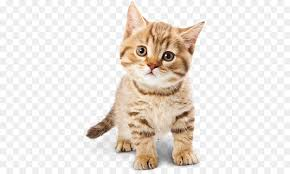

In [91]:
Image(f"tests/test_data/{private_stats.photos.iloc[0][0].get('uri')}")

And here are the other media types. Fell free to mess around with them.

In [92]:
len(private_stats.photos), len(private_stats.videos), len(private_stats.audios), len(private_stats.gifs), len(private_stats.files)

(3, 1, 1, 2, 2)

In [93]:
len(group_stats.photos),len(group_stats.videos), len(group_stats.audios), len(group_stats.gifs), len(group_stats.files)

(1, 0, 0, 1, 0)

##### Date and time related stats
The `get_grouped_time_series_data` function let's you group all stats into years, months, days and hours. Change the period parameter to one of these keywords' starting letter (e.g. day='d').

In [94]:
private_stats.get_grouped_time_series_data(timeframe='y')

,mc,text_mc,media_mc,wc,cc
timestamp,,,,,
2014-01-01,13,11,2,25,97
2018-01-01,3,3,0,32,170
2020-01-01,15,8,7,34,140


In [95]:
group_stats.get_grouped_time_series_data(timeframe='m')

,mc,text_mc,media_mc,wc,cc
timestamp,,,,,
2011-07-01,9,9,0,19,80
2018-04-01,9,7,2,21,86


The `stat_per_period` function is another interesting method. You can pass the same period values like in the `get_grouped_time_series_data` method, but here it will group by relative time range. For example group all the messages into 12 months, regardless which year they happened in.

You can have a pretty good insight on which parts of the year, week, or day are you active on Facebook Messenger.

In [96]:
private_stats.stats_per_timeframe(timeframe='m')

{'january': 3,
 'february': 10,
 'march': 1,
 'april': 2,
 'may': 1,
 'june': 0,
 'july': 0,
 'august': 1,
 'september': 1,
 'october': 0,
 'november': 10,
 'december': 2}

In [97]:
private_stats.stats_per_timeframe(timeframe='d')

{'monday': 7,
 'tuesday': 1,
 'wednesday': 6,
 'thursday': 3,
 'friday': 6,
 'saturday': 3,
 'sunday': 5}

In [98]:
group_stats.stats_per_timeframe(timeframe='h')

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 3,
 11: 5,
 12: 1,
 13: 9,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0}

#### Filtering
The filtering for `ConversationStats` works the same way as it works for `MessagingAnalyzer`. You can call it like this `stats.filter(**kwargs)` and it will return a narrower instance of itself. 

With the `.filter()` method we are filtering an underlying DataFrame behind the scenes. Here you can filter along the `channels` and `senders` dimensions, but this gets accompanied by `start`, `end` & `period`. All of these are now filtered on the DataFrame itself.

Let's start with `channels`.

In [99]:
prv_filtered_by_channel = private_stats.filter(channels=PARTNER_NAME)
prv_filtered_by_channel.channels

['Foo Bar']

In [100]:
grp_filtered_by_channel = group_stats.filter(channels=GROUP_NAME)
grp_filtered_by_channel.channels

['marathon']

Offtopic: now that we managed to get a single channel, we should mention that `ConversationStats` has the `creator` propery as well, that indicates who started the convo. Use it like this.

In [101]:
prv_filtered_by_channel.creator, grp_filtered_by_channel.creator

('Jenő Rejtő', 'Jenő Rejtő')

As you can see both of the above `ConversationStats` objects is filtered down to one convo. Let's now filter for senders.

In [102]:
prv_filtered_by_sender = private_stats.filter(senders=PARTNER_NAME)
prv_filtered_by_sender.channels

['Foo Bar']

In [103]:
grp_filtered_by_sender = group_stats.filter(senders=PARTNER_NAME)
grp_filtered_by_sender.channels

['Tőke Hal, Foo Bar, Donald Duck and 2 others',
 'Foo Bar, John Doe and Bugs Bunny',
 'marathon']

On the other hand here, the number of groups can be more. As many as the number of groups the person whos name is stored in `PERSON_NAME` is in. Now all of the messages this person sent in these conversations are in one single DataFrame and `ConversationStats` operates on this huge DataFrame. Let's check the dimensions of this df.

In [104]:
grp_filtered_by_sender.df.shape

(3, 4)

What you can also do now, is get all the messages from these groups, not just the one sent by `PARTNER_NAME`. Here is how.

In [105]:
grp_filtered_for_channels = group_stats.filter(channels=grp_filtered_by_sender.channels)

len(grp_filtered_for_channels.channels), len(grp_filtered_by_sender.channels)

(3, 3)

As you will see this new object has much greater dimensions.

In [106]:
grp_filtered_for_channels.df.shape

(18, 6)

Anyway, I think you get the idea now. These filtering methods are pretty flexible, maybe a bit less intuitive. Further developments may improve on this.

But let's see now how can you filter by date. There are several ways actually. You can start by applying no filters.

In [107]:
private_stats_for_partner = private_stats.filter(channels=PARTNER_NAME)
private_stats_filtered_by_date = private_stats_for_partner.filter(channels=PARTNER_NAME, start=None, end=None, period=None)

private_stats_for_partner.df.shape, private_stats_filtered_by_date.df.shape

((15, 10), (15, 10))

Filter by `start` and `end` is pretty intuitive. You can use both datetime objects and strings (however note that you can only use strings in this format `%Y-%m-%d` as defined in [ISO_8601](https://en.wikipedia.org/wiki/ISO_8601)). Feel free to play areound with these filter parameters.

In [108]:
stats_by_start_end = private_stats_for_partner.filter(start='2015-05-05', end='2016-05-05')
stats_by_start_end.df.shape

(0, 0)

In [109]:
start =datetime(year=2015, month=5, day=5)
end = datetime(year=2016, month=6, day=6)
stats_by_start_end = private_stats_for_partner.filter(start=start, end=end)
stats_by_start_end.df.shape

(0, 0)

We can filter only by start. That means we will get all the messages from start entil the last message.

In [110]:
stats_by_start = private_stats_for_partner.filter(start='2015-05-05')

Filtering only by end means you gety all the messages from the first one until the end timestamp.

In [111]:
stats_by_end = private_stats_for_partner.filter(end='2016-06-06')

Filtering by `period` is less intuitive. `period` in this context means a year, a month, a day, an hour. It is not so flexible, but pretty comfortable to use. You have to use `period` with either `start` or `end`. With `start` it's like the following equation `from start to start+period` and with `end` it's like `from end-period to end`.

In [112]:
stats_by_start_period = private_stats_for_partner.filter(start='2015-05-05', period='y')

In [113]:
stats_by_end_period = private_stats_for_partner.filter(end='2016-05-05', period='y')

These should have the same dimensions.

In [114]:
stats_by_start_period.df.shape, stats_by_end_period.df.shape

((0, 0), (0, 0))

### Report
...soon

### People
...soon

### Plots
...soon

## Final words
So that is about it. Hope this notebook helped a little bit in understanding how this application works and what can you do with it.

I'm sure the capabilities/features would change in the future, but I would like to keep this interface as much as I can. On the other hand, I'm open to new/better ideas.